<a href="https://colab.research.google.com/github/LucasNH/CSC413-Final-Project/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install torchtext package and load data
Download the files `reuters_train.txt` and `reuters_valid.txt`, and upload them to Google Drive.

Then, mount Google Drive from your Google Colab notebook:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

In [ ]:
!pip install torchtext==0.6.0

In [ ]:
import gc
gc.collect()

9616

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
file_path =  '/content/gdrive/MyDrive/Colab Notebooks/data/arxiv.txt'

We will be using PyTorch's `torchtext` utilities to help us load, process,
and batch the data. This package is useful, but takes a bit of time to get
used to.

We'll be using a `TabularDataset` to load our data, which works well on structured
CSV data with fixed columns (e.g. a column for the sequence, a column for the label). Our tabular dataset
is even simpler: we have no labels, just some text. So, we are treating our data as a table with one field
representing our sequence.

In [ ]:
import torchtext

# Tokenization function to separate a title into words
def tokenize_title(title):
    """Returns the sequence of words in the string title. We also
    prepend the "<bos>" or beginning-of-string token, and append the
    "<eos>" or end-of-string token to the title.
    """
    return ("<bos> " + title + " <eos>").split()

# Data field (column) representing our *text*.

text_field = torchtext.data.Field(
    sequential=True,            # this field consists of a sequence
    tokenize=tokenize_title, # how to split sequences into words
    include_lengths=True,       # to track the length of sequences, for batching
    batch_first=True,           # similar to batch_first=True in nn.RNN demonstrated in lecture
    use_vocab=True)             # to turn each character into an integer index

full_dataset = torchtext.data.TabularDataset(
    path=file_path,                 # data file path
    format="tsv",                   # fields are separated by a tab
    fields=[('title', text_field)]) # list of fields (we have only one)

# Split the dataset into train and validation sets (80/20 split)
train_data, val_data = full_dataset.split(split_ratio=0.8)

# Data Exploration

### Number of Words per Headline



['<bos>', 'Cactus', 'Mechanisms', ':', 'Optimal', 'Differential', 'Privacy', 'Mechanisms', 'in', 'the', 'Large', '-', 'Composition', 'Regime', '<eos>']
['<bos>', 'A', 'grid', '-', 'point', 'detection', 'method', 'based', 'on', 'U', '-', 'net', 'for', 'a', 'structured', 'light', 'system', '<eos>']


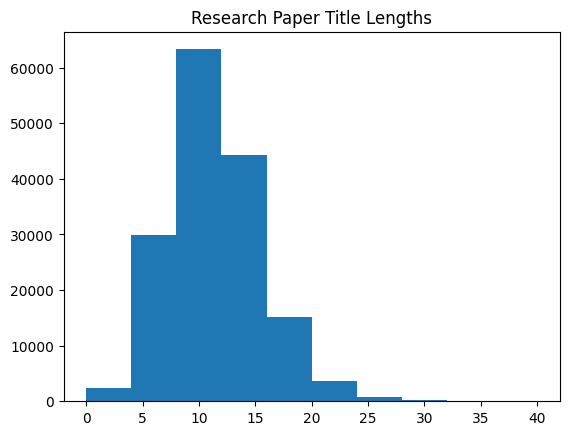

In [ ]:
# Include your histogram and your written explanations

# Here is an example of how to plot a histogram in matplotlib:
# plt.hist(np.random.normal(0, 1, 40), bins=)

word_counts = [len(x.title) - 2 for x in train_data] # Exclude <bos>, <eos>
plt.figure()
plt.hist(word_counts, bins=10, range=(0, 40))
plt.title('Research Paper Title Lengths')
plt.savefig('title_lengths.png')

# Here are some sample code that uses the train_data object:
print(train_data[5].title)
for example in train_data:
    print(example.title)
    break

### Number of Distinct Words in Training Data

How many distinct words appear in the training data?
Exclude the `<bos>` and `<eos>` tags in your computation.

In [ ]:
# of distinct words in the training data

# You might find the python class Counter from the collections package useful
from collections import Counter
words_cnt = Counter()
for x in train_data:
  words_cnt.update(x.title[1:-1])

print(f'Distinct Words: {len(words_cnt)}')

Distinct Words: 61191


In [ ]:
# Report your values here. Make sure that you report the actual values,
# and not just the code used to get those values


word_freqs = [(word, count) for (word, count) in words_cnt.items()]

appear_once = [word for (word, count) in word_freqs if count == 1]
appear_twice = [word for (word, count) in word_freqs if count == 2]

print(f"Appearing Once: {appear_once[:10]}")
print(f"Appearing Twice: {appear_twice[:10]}")

Appearing Once: ['CAFIN', 'tableaux', 'SDSRA', 'HATP', 'fractals', 'railway', 'Husserlian', 'phenomenology', 'TauPETGen', 'AAIA']
Appearing Twice: ['roots', 'IN', 'HTS', 'AT', 'phenotypic', 'Myeloid', 'opcode', 'concavity', 'MLN', 'Olympic']


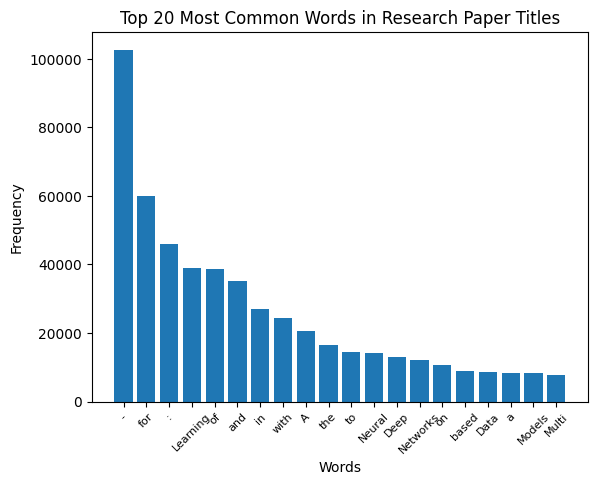

In [ ]:
# Get the most common words and their frequencies
most_common_words = words_cnt.most_common(20)  # You can change 10 to show a different number of words

# Extract words and frequencies
words, frequencies = zip(*most_common_words)

# Create a bar graph
plt.bar(words, frequencies)
plt.xticks(rotation=45, fontsize=8)
plt.title('Top 20 Most Common Words in Research Paper Titles')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.savefig('word_frequencies.png')
plt.show()

### Justification for using \<unk\> token


Words in the validation set that do not appear during training will not have have an associated embeddings.


### Limit vocab size to 1000 most frequent words

We will only model the top 9995 words in the training set, excluding the tags
`<bos>`, `<eos>`, and other possible tags we haven't mentioned yet
(including those, we will have a vocabulary size of exactly 10000 tokens).

What percentage of word occurrences will be supported? Alternatively, what percentage
of word occurrences in the training set will be set to the `<unk>` tag?

In [ ]:
# Report your values here. Make sure that you report the actual values,
# and not just the code used to get those values

top_words = words_cnt.most_common(9995)
total = len(list(words_cnt.elements()))

total_kept = 0
for _, cnt in top_words:
  total_kept += cnt

print(f'Percentage of occurrences supported: {total_kept / total}')

Our `torchtext` package will help us keep track of our list of unique words, known
as a **vocabulary**. A vocabulary also assigns a unique integer index to each word.
You can interpret these indices as sparse representations of one-hot vectors.

In [ ]:
# Build the vocabulary based on the training data. The vocabulary
# can have at most 9997 words (9995 words + the <bos> and <eos> token)
text_field.build_vocab(train_data, max_size=9997)

# This vocabulary object will be helpful for us
vocab = text_field.vocab
print(vocab.stoi["hello"]) # for instances, we can convert from string to (unique) index
print(vocab.itos[10])      # ... and from word index to string

# The size of our vocabulary is actually 10000
vocab_size = len(text_field.vocab.stoi)
print(vocab_size) # should be 10000


# The reason is that torchtext adds two more tokens for us:
print(vocab.itos[0]) # <unk> represents an unknown word not in our vocabulary
print(vocab.itos[1]) # <pad> will be used to pad short sequences for batching

0
in
10000
<unk>
<pad>


# Autoencoder implementation

Complete the code for the AutoEncoder class below by:

1. Filling in the missing numbers in the `__init__` method using
   the parameters `vocab_size`, `emb_size`, and `hidden_size`. (4 points)
2. Complete the `forward` method, which uses teacher forcing
   and computes the logits $z^{(t)}$ of the reconstruction of
   the sequence. (4 points)

You should first try to understand the `encode` and `decode` methods,
which are written for you. The `encode` method mimics a discriminative
RNN (see the sentiment analysis notebook).  The `decode` method is
a generative RNN and is a bit more complex (see the text generation
tutorial notebook).  You might want to scroll down to the
`sample_sequence` function to see how this function will be called.

You can (but don't have to) use the `encode` and `decode` method in
your `forward` method. In either case, be very careful of the input
that you feed into ether `decode` or to `self.decoder_rnn`.
Refer to the teacher-forcing diagram.

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        """
        A text autoencoder. The parameters
            - vocab_size: number of unique words/tokens in the vocabulary
            - emb_size: size of the word embeddings $x^{(t)}$
            - hidden_size: size of the hidden states in both the
                           encoder RNN ($h^{(t)}$) and the
                           decoder RNN ($m^{(t)}$)
        """
        super().__init__()
        self.embed = nn.Embedding(num_embeddings=vocab_size,
                                  embedding_dim=emb_size)
        self.encoder_rnn = nn.GRU(input_size=emb_size,
                                  hidden_size=hidden_size,
                                  batch_first=True)
        self.decoder_rnn = nn.GRU(input_size=emb_size,
                                  hidden_size=hidden_size,
                                  batch_first=True)
        self.proj = nn.Linear(in_features=hidden_size,
                              out_features=vocab_size)

    def encode(self, inp):
        """
        Computes the encoder output given a sequence of words.
        """
        emb = self.embed(inp)
        out, last_hidden = self.encoder_rnn(emb)
        return last_hidden

    def decode(self, inp, hidden=None):
        """
        Computes the decoder output given a sequence of words, and
        (optionally) an initial hidden state.
        """
        emb = self.embed(inp)
        out, last_hidden = self.decoder_rnn(emb, hidden)
        out_seq = self.proj(out)
        return out_seq, last_hidden

    def forward(self, inp):
        """
        Compute both the encoder and decoder forward pass
        given an integer input sequence inp with shape [batch_size, seq_length],
        with inp[a,b] representing the (index in our vocabulary of) the b-th word
        of the a-th training example.

        This function should return the logits $z^{(t)}$ in a tensor of shape
        [batch_size, seq_length - 1, vocab_size], computed using *teaching forcing*.

        The (seq_length - 1) part is not a typo. If you don't understand why
        we need to subtract 1, refer to the teacher-forcing diagram above.
        """

        last_hidden = self.encode(inp)
        # print(last_hidden.shape) # Should be [1, batch_size, hidden_size]

        # Why do we have L - 1 logits?
        # We do not pass the <eos> token to the Autoencoder, as there is no
        # "next word" to sample.

        out_seq, last_hidden = self.decode(inp, last_hidden)
        # print(out_seq.shape) # should be [batch_size, seq_length, vocab_size]

        return out_seq[:, :-1, :]

### Training the Autoencoder using Teacher Forcing

To check that your model is set up correctly, we'll train our AutoEncoder
neural network for at least 300 iterations to memorize this sequence:

[Iter 10] Loss 0.111032 Validation Loss 0.707095
[Iter 20] Loss 0.108515 Validation Loss 0.664001
[Iter 30] Loss 0.105743 Validation Loss 0.681288
[Iter 40] Loss 0.091291 Validation Loss 0.646989
[Iter 50] Loss 0.111706 Validation Loss 0.647040
[Iter 60] Loss 0.118073 Validation Loss 0.619045
[Iter 70] Loss 0.102800 Validation Loss 0.606340
[Iter 80] Loss 0.116383 Validation Loss 0.566202
[Iter 90] Loss 0.083954 Validation Loss 0.558155
[Iter 100] Loss 0.082634 Validation Loss 0.553489


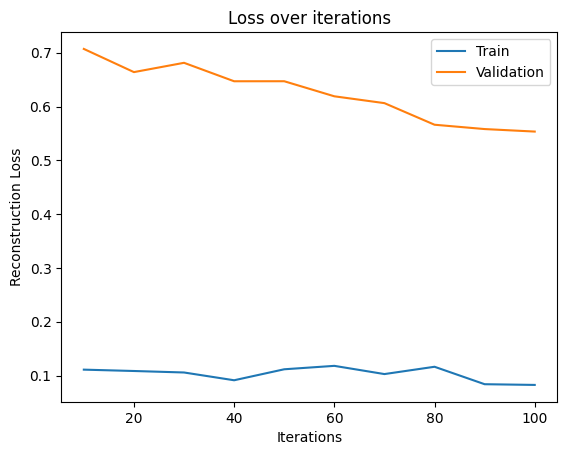

In [ ]:
model = AutoEncoder(vocab_size, 128, 128)

def train_autoencoder(model, batch_size=32, learning_rate=0.001, num_epochs=1, plot_every=10, make_plot=True):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for ep in range(num_epochs):


        train_loss, valid_loss, iters = [], [], []

        # This BucketIterator will handle padding of sequences that are not of the same length
        train_iter = torchtext.data.BucketIterator(train_data,
                                                   batch_size=batch_size,
                                                   sort_key=lambda x: len(x.title), # to minimize padding
                                                   repeat=False,
                                                   shuffle=True)


        valid_iter = torchtext.data.BucketIterator(val_data,
                                                   batch_size=batch_size,
                                                   sort_key=lambda x: len(x.title), # to minimize padding
                                                   repeat=False,
                                                   shuffle=True)


        it = 0
        for e in range(num_epochs):
          for ((xs, lengths), _) in train_iter:
              it += 1

              # Fill in the training code here
              zs = model(xs) # output logits from the decoder [B, L - 1, vocab_size]
              zs = torch.permute(zs, (0, 2, 1)) # correct shape for loss fn is [B, vocab_size, L - 1]
              targets = xs[:,1:] # Shape is [B, L - 1] (we don't generate the first token in the input sequence, <bos>)

              loss = criterion(zs, targets)
              loss.backward()
              optimizer.step()


              if (it) % plot_every == 0:
                  tr_loss = (float(loss)) / batch_size
                  train_loss.append(tr_loss)


                  # Optional: Compute and track validation loss
                  val_loss = 0
                  val_n = 0
                  for ((xs, lengths), _) in valid_iter:
                    zs = model(xs)
                    zs = torch.permute(zs, (0, 2, 1))
                    targets = xs[:,1:]
                    loss = criterion(zs, targets)
                    val_loss += float(loss) / batch_size

                    if val_n == 5:
                      break
                    val_n += 1


                  valid_loss.append(val_loss)
                  iters.append((it))


                  print("[Iter %d] Loss %f Validation Loss %f" % (it, tr_loss, val_loss ))

              optimizer.zero_grad()
              if it == 100:
                break


        if make_plot:
          plt.figure()
          plt.plot(iters[:len(train_loss)], train_loss)
          plt.plot(iters[:len(valid_loss)], valid_loss)
          plt.title("Loss over iterations")
          plt.xlabel("Iterations")
          plt.ylabel("Reconstruction Loss")
          plt.legend(["Train", "Validation"])
          plt.savefig('autoencoder_train.png')

        torch.save(model, 'model_baseline.pt')


train_autoencoder(model)

### Sampling sequences from the decoder


We are sampling from a multi-nomial distribution described by the logits $z^{(t)}$.For example, if our distribution is [80%, 20%]
over a vocabulary of two words, then we will choose the first word
with 80% probability and the second word with 20% probability.


In [ ]:
def sample_sequence(model, hidden, max_len=20, temperature=1):
    """
    Return a sequence generated from the model's decoder
        - model: an instance of the AutoEncoder model
        - hidden: a hidden state (e.g. computed by the encoder)
        - max_len: the maximum length of the generated sequence
        - temperature: described in Part (d)
    """
    # We'll store our generated sequence here
    generated_sequence = []
    # Set input to the <BOS> token
    inp = torch.Tensor([text_field.vocab.stoi["<bos>"]]).long()
    for p in range(max_len):
        # compute the output and next hidden unit
        output, hidden = model.decode(inp.unsqueeze(0), hidden)
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0])
        # Add predicted word to string and use as next input
        word = text_field.vocab.itos[top_i]
        # Break early if we reach <eos>
        if word == "<eos>":
            break
        generated_sequence.append(word)
        inp = torch.Tensor([top_i]).long()
    return generated_sequence

train_dataloader = torchtext.data.BucketIterator(train_data, 32,
                                                     train=True, sort_key=lambda x: len(x.title),
                                                      device=None)
X = next(iter(train_dataloader))
titles = X.title[0]

for title in titles[:20]:

  print(f"Input Title: {tokens_to_text(title)}")
  hidden = model.encode(title.expand(1, -1))
  out_seq = sample_sequence(model, hidden)
  out_seq = " ".join(out_seq)
  print(f"Reconstructed Title: {out_seq}")

Input Title:  Expressing Visual Relationships via Language 
Reconstructed Title: <unk> Contrastive Reinforcement Agent Pointer Learning : and Combinations Classifier
Input Title:  Simulation of <unk> Hurricane Tracks and Features : A Deep Learning Approach 
Reconstructed Title: to Diverse Deep on and losses <pad> Learning
Input Title:  Cluster - based trajectory segmentation with local noise 
Reconstructed Title: and Langevin Check Sign Games Effective and Quantum Multi Classification as - for Inverse Networks
Input Title:  SMART : Robust and Efficient Fine - Tuning for Pre - trained Natural Language Models through Principled Regularized Optimization 
Reconstructed Title: <unk> Learning Text Systems <unk> An Robust <unk> Extraction
Input Title:  Towards interpreting ML - based automated malware detection models : a survey 
Reconstructed Title: Threshold on Good Flexible of with Tuning ordering Machine Nonlinear Sets biomarkers drug images Networks
Input Title:  Selection via Proxy : Ef

In [ ]:
title = titles[0]

# The temperature setting makes the multinomial distribution flatter (e.g. more likely to generate different words)
# or peakier (e.g. less likely to generate different words).

for temp in [1.5, 2, 5]:
  hidden = model.encode(title.expand(1, -1))
  out_seq = sample_sequence(model, hidden)
  out_seq = " ".join(out_seq)
  print(out_seq)

# Denoising Adversarial Autoencoder



We add noise to our data in the following ways:

1. Shuffle the words in the headline, taking care that words don't end up too far from where they were initially
2. Drop (remove) some words
3. Replace some words with a blank word (a `<pad>` token)
4. Replace some words with a random word

When we train our `Autoencoder` on this noisy data, we expect that the Autoencoder will reconstruct sentences without noise. This augmentation is done
to prevent the Autoencoder from overfitting to the data. The trained Autoencoder is called a Denoising Autoencoder.


In [ ]:
def tokenize_and_randomize(title,
                           drop_prob=0.1,  # probability of dropping a word
                           blank_prob=0.1, # probability of "blanking" out a word
                           sub_prob=0.1,   # probability of substituting a word with a random one
                           shuffle_dist=3): # maximum distance to shuffle a word
    """
    Add 'noise' to a title by slightly shuffling the word order,
    dropping some words, blanking out some words (replacing with the <pad> token)
    and substituting some words with random ones.
    """
    title = title
    n = len(title)
    # shuffle
    title = [title[i] for i in get_shuffle_index(n, shuffle_dist)]

    new_title = [vocab.stoi['<bos>']]
    for w in title:
        if random.random() < drop_prob:
            # drop the word
            pass
        elif random.random() < blank_prob:
            # replace with blank word
            new_title.append(vocab.stoi["<pad>"])
        elif random.random() < sub_prob:
            # substitute word with another word
            new_title.append(random.randint(0, vocab_size - 1))
        else:
            # keep the original word
            new_title.append(w)
    new_title.append(vocab.stoi['<eos>'])
    return new_title

def get_shuffle_index(n, max_shuffle_distance):
    """ This is a helper function used to shuffle a headline with n words,
    where each word is moved at most max_shuffle_distance. The function does
    the following:
       1. start with the *unshuffled* index of each word, which
          is just the values [0, 1, 2, ..., n]
       2. perturb these "index" values by a random floating-point value between
          [0, max_shuffle_distance]
       3. use the sorted position of these values as our new index
    """
    index = np.arange(n)
    perturbed_index = index + np.random.rand(n) * 3
    new_index = sorted(enumerate(perturbed_index), key=lambda x: x[1])
    return [index for (index, pert) in new_index]

In [ ]:
text_field = torchtext.data.Field(
    sequential=True,            # this field consists of a sequence
    tokenize=tokenize_and_randomize, # how to split sequences into words
    include_lengths=True,       # to track the length of sequences, for batching
    batch_first=True,           # similar to batch_first=True in nn.RNN demonstrated in lecture
    use_vocab=True)             # to turn each character into an integer index

full_dataset = torchtext.data.TabularDataset(
    path=file_path,                 # data file path
    format="tsv",                   # fields are separated by a tab
    fields=[('title', text_field)]) # list of fields (we have only one)

# Split the dataset into train and validation sets (80/20 split)
train_data, val_data = full_dataset.split(split_ratio=0.8)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class AdversarialAutoencoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, lambda_param):
        super().__init__()

        # Encoder, Decoder, and Discriminator from the provided AutoEncoder class
        self.autoencoder = AutoEncoder(vocab_size, emb_size, hidden_size)

        # Discriminator network
        self.discriminator = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

        self.lambda_param = lambda_param

    def encode(self, inp):
        return self.autoencoder.encode(inp)

    def decode(self, inp, hidden=None):
        return self.autoencoder.decode(inp, hidden)

    def forward(self, inp):
        return self.autoencoder(inp)


# Replace with your actual vocabulary size
emb_size = 128  # Replace with your desired embedding size
hidden_size = 128  # Replace with your desired hidden size
lambda_param = 0.1  # Replace with your desired lambda value

model = AdversarialAutoencoder(vocab_size, 128, 128,lambda_param)

In [ ]:
# Convert tensors to lists of integers
def convert_tensor_to_list(tensor):
    return tensor.tolist() if torch.is_tensor(tensor) else tensor

[Iter 10] Rec Loss 7.676515, Adv Loss 0.802286, Valid Loss 8.536819
[Iter 20] Rec Loss 6.420492, Adv Loss 0.885412, Valid Loss 6.542474
[Iter 30] Rec Loss 4.813508, Adv Loss 0.736234, Valid Loss 5.533571
[Iter 40] Rec Loss 3.390304, Adv Loss 0.843683, Valid Loss 4.918132
[Iter 50] Rec Loss 3.957568, Adv Loss 0.694959, Valid Loss 4.561101
[Iter 60] Rec Loss 4.075193, Adv Loss 0.900738, Valid Loss 4.264250
[Iter 70] Rec Loss 3.193371, Adv Loss 0.850922, Valid Loss 4.565271
[Iter 80] Rec Loss 3.450527, Adv Loss 0.692505, Valid Loss 4.116969
[Iter 90] Rec Loss 2.998865, Adv Loss 0.724533, Valid Loss 4.427223
[Iter 100] Rec Loss 3.702621, Adv Loss 0.782739, Valid Loss 4.469683


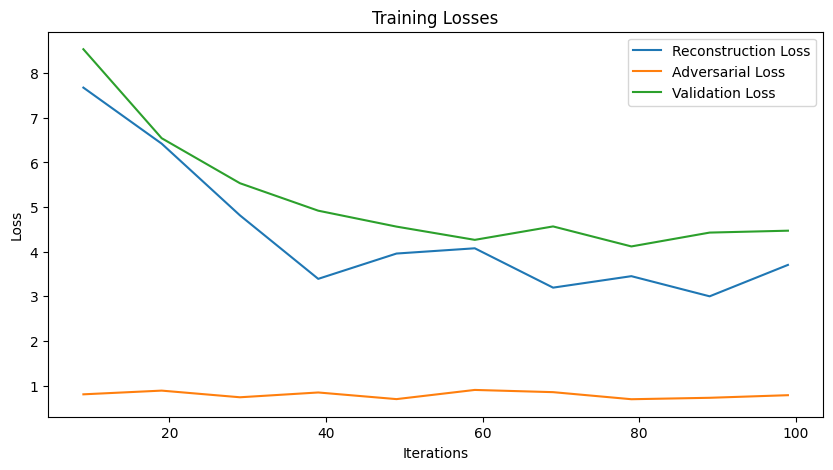

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import matplotlib.pyplot as plt

def train_daae(model, batch_size=32, num_epochs=1, plot_every=10, make_plot=True):
    optimizer_ae = optim.Adam(model.autoencoder.parameters(), lr=0.001)
    optimizer_discriminator = optim.Adam(model.discriminator.parameters(), lr=0.001)
    criterion_rec = nn.CrossEntropyLoss()
    criterion_adv = nn.BCELoss()



     # We will perform data augmentation by re-reading the input each time
    field = torchtext.data.Field(sequential=True,
                                  tokenize=tokenize_and_randomize, # <-- data augmentation
                                  include_lengths=True,
                                  batch_first=True,
                                  use_vocab=False, # <-- the tokenization function replaces this
                                  pad_token=vocab.stoi['<pad>'])


    dataset = torchtext.data.TabularDataset(file_path, "tsv", [('title', field)])
    train_data, val_data = full_dataset.split(split_ratio=0.8)



    train_iter = torchtext.data.BucketIterator(train_data, batch_size,
                                                train=True, repeat=True,
                                                sort_key=lambda x: len(x.title),
                                                device=None)


    valid_iter = torchtext.data.BucketIterator(val_data,
                                              batch_size=batch_size,
                                              sort_key=lambda x: len(x.title), # to minimize padding
                                              repeat=False)



    iters, train_loss_rec, train_loss_adv, valid_loss = [], [], [], []

    it = 0
    for e in range(num_epochs):
      for ((xs, lengths), _) in train_iter:
          it += 1

          # Forward pass through autoencoder
          zs = model(xs)
          zs = zs.permute(0, 2, 1)

          # Reconstruction loss
          targets = xs[:, 1:]
          loss_rec = criterion_rec(zs, targets)

          # Adversarial loss
          z = model.encode(xs)
          pred_real = model.discriminator(z)
          loss_adv_real = criterion_adv(pred_real, torch.ones_like(pred_real))
          z_fake = torch.randn_like(z).detach()
          pred_fake = model.discriminator(z_fake)
          loss_adv_fake = criterion_adv(pred_fake, torch.zeros_like(pred_fake))
          loss_adv = loss_adv_real + loss_adv_fake

          # Total loss
          optimizer_ae.zero_grad()
          optimizer_discriminator.zero_grad()

          total_loss = loss_rec + model.lambda_param * loss_adv

          # Backward pass
          total_loss.backward()

          optimizer_ae.step()
          optimizer_discriminator.step()

          if (it + 1) % plot_every == 0:

              iters.append(it)
              train_loss_rec.append(float(loss_rec))
              train_loss_adv.append(float(loss_adv))


              # Optional: Compute and track validation loss
              val_loss = 0
              val_n = 0
              for ((xs, lengths), _) in valid_iter:
                zs = model(xs)
                zs = torch.permute(zs, (0, 2, 1))
                targets = xs[:,1:]
                loss = criterion_rec(zs, targets)
                val_loss += float(loss)

                if val_n == 5:
                  break

                val_n += 1


              val_loss /= val_n
              valid_loss.append(val_loss)
              print("[Iter %d] Rec Loss %f, Adv Loss %f, Valid Loss %f" % (it + 1, float(loss_rec), float(loss_adv), float(val_loss)))


          if it == 100:
            break



    # Plotting
    if make_plot:
      plt.figure(figsize=(10, 5))
      plt.plot(iters, train_loss_rec, label='Rec Loss')
      plt.plot(iters, train_loss_adv, label='Adv Loss')
      plt.plot(iters, valid_loss, label='Valid Loss')
      plt.legend(["Reconstruction Loss", "Adversarial Loss", "Validation Loss"])
      plt.xlabel('Iterations')
      plt.ylabel('Loss')
      plt.title('Training Losses')
      plt.savefig('daae_train.png')
      plt.show()


    torch.save(model, 'model_daae.pt')



# Train the DAAE model
train_daae(model)


# Studying the Latent Space Constructed by the Autoencoder

In [ ]:
# Save the model


# Load the model
# loaded_model = DenoisAdversarialAutoencoder(vocab_size, emb_size, hidden_size, lambda_param)
# loaded_model.load_state_dict(torch.load('model.pth'))
loaded_model = torch.load("model_baseline.pt")

In [ ]:
def l_emb_size_norm(a, b, emb_size):
    distance = 0
    for i in range(emb_size):
        distance += ((a[i].item() - b[i].item()) ** emb_size)
    distance ** (1 / emb_size)
    return distance

In [ ]:
import gc
gc.collect()

599934

In [ ]:
import heapq

input_embd = torch.tensor([-1.0000, -1.0000, -0.9136,  1.0000, -1.0000,  1.0000, -0.5133, -0.9744,
         -1.0000,  0.8250,  0.3641,  1.0000, -1.0000,  0.7279, -0.7730,  1.0000,
          1.0000,  0.1633,  0.2159, -0.3960, -0.9996, -0.9841,  0.9816,  1.0000,
         -0.4607,  1.0000,  0.9734,  0.1995,  0.9950,  1.0000, -1.0000, -0.9969,
         -0.9999, -0.6956, -0.9886, -1.0000, -1.0000, -1.0000,  0.9003, -0.9822,
         -0.9932, -0.9944,  0.2616,  0.3027, -0.9998,  1.0000, -1.0000, -0.9834,
         -0.5915, -0.5423,  0.8798,  1.0000, -1.0000,  1.0000, -1.0000, -1.0000,
         -1.0000,  1.0000,  1.0000, -0.9998, -1.0000, -0.1092,  0.2921, -0.9147,
          0.9993, -0.9999, -0.9998, -0.3213,  0.0570,  1.0000, -0.9227,  1.0000,
          0.6010, -1.0000, -0.8422,  0.9386, -0.9998,  1.0000,  1.0000,  0.9844,
          1.0000, -1.0000, -0.0263,  1.0000,  1.0000,  0.9958,  0.6430,  0.8459,
         -1.0000,  1.0000, -0.6944, -0.6967, -1.0000, -1.0000,  0.9893, -1.0000,
         -1.0000, -1.0000,  0.9990, -0.9999,  0.7598,  0.9125, -0.9892, -1.0000,
         -1.0000, -0.8344, -0.6442,  1.0000, -0.9629, -0.7997, -0.9666, -1.0000,
         -1.0000,  0.0574, -1.0000,  1.0000,  0.9998,  1.0000,  1.0000, -1.0000,
         -0.9991,  1.0000,  0.5798,  1.0000, -1.0000,  1.0000, -1.0000,  1.0000])


def get_similar_titles_approx(query_title, max_dist=9e+29):
  train_dataloader = torchtext.data.BucketIterator(train_data, 32,
                                            train=True, repeat=True,
                                            shuffle=True, device=None)

  top_five = []
  input_embd = model.encode(query_title)

  X = next(iter(train_dataloader)).title[0]

  while len(top_five) < 5 and 0 != len(X):
      for title in X:
          embedding = loaded_model.encode(title)
          dist = l_emb_size_norm(input_embd[0], embedding[0], 128) / 1e+35
          print(dist)

          if dist < max_dist:
              top_five.append([embedding, title])

      X = next(iter(train_dataloader)).title[0]
      gc.collect()

  return top_five



def get_similar_titles(query_title):
  train_iter = torchtext.data.BucketIterator(train_data, 32,
                                                   train=True, repeat=True,
                                                  shuffle=True, device=None)
  top_k = []
  heapq.heapify(top_k)
  k = 5

  input_emb = model.encode(query_title)
  print(input_emb)
  count = 0
  for ((xs, lengths), _) in train_iter:

    for title in xs:

      embedding = loaded_model.encode(title)
      dist = l_emb_size_norm(input_emb[0], embedding[0], 128) / 1e+35

      if len(top_k) < 5:
        heapq.heappush(top_k, (dist, (embedding, title)))
      else:
        heapq.heappushpop(top_k, (dist, (embedding, title)))
      count += 1

      if count == 5000:
        return top_k



  return top_k




In [ ]:
def tokens_to_text(tokens):
  text = ""
  for token in tokens:
    text += " {}".format(vocab.itos[token])
  return text[text.index('<bos>') + 5: text.index('<eos>')]



train_dataloader = torchtext.data.BucketIterator(train_data, 32,
                                            train=True, repeat=True,
                                            shuffle=True, device=None)

query_title = next(iter(train_dataloader)).title[0][5]
query_title_tokens = list(query_title)
print(f"Query Title: {tokens_to_text(query_title_tokens)}")

top_five = get_similar_titles(query_title)


print("=== RECOMMENDATIONS ===")
for i, (dist, (_, title)) in enumerate(top_five):
  title_tokens = list(title)
  print(f"Hit {i + 1}: {tokens_to_text(title_tokens)}, Distance: {dist}")


Query Title:  Policy Learning of MDPs with Mixed Continuous / Discrete Variables : A Case Study on Model - Free Control of Markovian Jump Systems 


NameError: ignored

In [ ]:
# print(embeddings_dictionary)

# print(input_embd[2].item())

# for key, value in embeddings_dictionary.items():
    # print(cos(target_embd, key))
    # print(l_emb_size_norm(input_embd, key[0], 128))
    # print(key[0])
    # break